In [1]:
import efficientnet.tfkeras as efn
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from PIL import Image
from scipy.ndimage.interpolation import rotate
import pickle
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations as A
from sklearn.model_selection import StratifiedKFold

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:

root_dir = '/home/b170007ec/Programs/Manoj/CLASSIFIER/ROIS'
img_dirs = []
labels = []
for file in os.listdir(root_dir):
    file_dir = os.path.join(root_dir,file)
    img_dirs.append(file_dir)
    file_list = file.split('_')
    try :
        labels.append(int(file_list[-2])-1)
    except ValueError:
        labels.append(int(file_list[-3])-1)

In [5]:
test_dir = img_dirs[:100]
test_labels = labels[:100]
print(len(img_dirs))
img_dirs = img_dirs[100:]
labels = labels[100:]
data = (img_dirs,labels)
print(len(img_dirs))

4728
4628


In [41]:
INPUT_SIZE = 512
BATCH_SIZE = 2
VALID_SPLIT = 0.1
stride_obj=2
EPOCHS = 100
input_size_obj=512
output_size_obj = input_size_obj//stride_obj
ALPHA = 2.0
GAMMA = 4.0
LR = 0.001

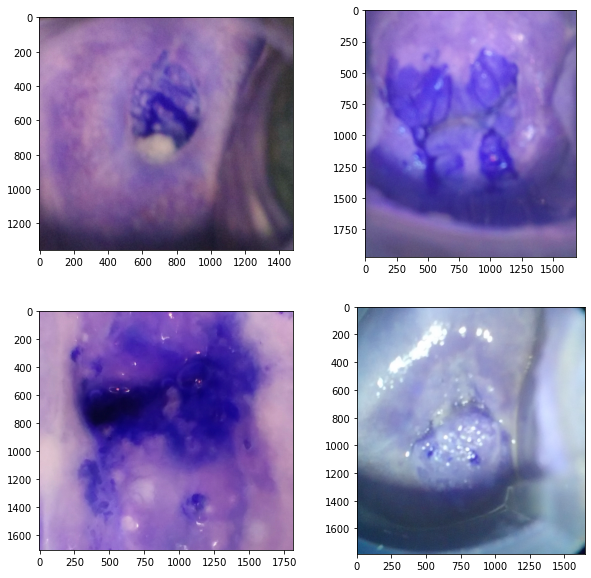

In [42]:
#random viz
def ran_viz():
    images = []
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    images = random.choices(img_dirs,k=4)
    for i,img in enumerate(images):
        img = np.load(img)
        ax[i//2][i%2].imshow(img)
ran_viz()

In [43]:
def aug(max_angle=90):
    a = A.Compose([A.Rotate(limit = max_angle,p=1)])
    return a
#generator
class Generator(Sequence):
    def __init__(self,data,batch_size=BATCH_SIZE,input_size=INPUT_SIZE,is_train = True):
        self.img_dirs = data[0]
        self.labels = data[1]
        self.batch_size = batch_size
        self.input_size = input_size
        self.is_train = is_train
        if self.is_train:
            self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.img_dirs)/float(self.batch_size)))
    def on_epoch_end(self):
        if self.is_train:
            temp = list(zip(self.img_dirs,self.labels)) 
            shuffle(temp) 
            self.img_dirs, self.labels = zip(*temp)
    def __getitem__(self,idx):
        train_x = self.img_dirs[self.batch_size*idx:self.batch_size*(idx+1)]
        train_y =  self.labels[self.batch_size*idx:self.batch_size*(idx+1)]
        return self.generate(train_x,train_y)
    def generate(self,train_x,train_y):
        X = []
        Y = []
        for i,img in enumerate(train_x):
            y = np.zeros(3)
            y[train_y[i]] = 1
            image = np.load(img)
            #image = cv2.resize(image,(self.input_size,self.input_size))
            roi = cv2.resize(image,(self.input_size,self.input_size))
            #img = np.concatenate([roi,image],axis=-1)
            X.append(roi/255)
            if self.is_train:
                data = {'image':roi}
                roi = aug()(**data)
                roi = roi['image']
                X.append(roi/255)
                Y.append(y)
            Y.append(y)
        return np.asarray(X), np.asarray(Y)

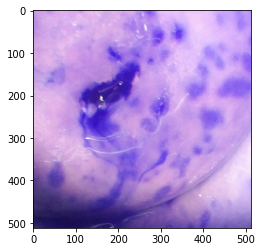

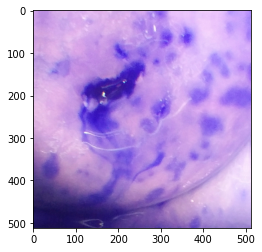

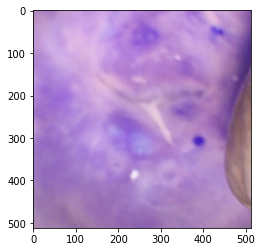

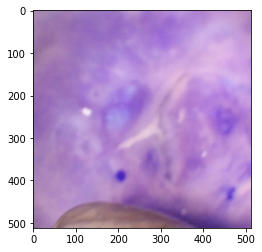

In [44]:
#testing generator
data = (img_dirs,labels)
def test(data,i):
    gen = Generator(data,batch_size = 2,input_size=INPUT_SIZE,is_train=True)
    X,Y = gen.__getitem__(i)
    for x,y in zip(X,Y):
        plt.imshow(x)
        plt.show()
test(data,3)

In [45]:
#efficientnet encoder
encoder = efn.EfficientNetB4(include_top=False,input_shape = (INPUT_SIZE,INPUT_SIZE,3))
encoder.summary()

Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [46]:
def focal_loss(alpha,gamma):
    def loss_fn(y_true,y_pred):
        y_pred = K.clip(y_pred,1e-5,1-1e-5)
        loss = alpha*((1-y_pred)**gamma)*y_true*K.log(y_pred)
        loss = -K.sum(loss,axis=-1)
        return loss
    return loss_fn

In [47]:
def build_model(ALPHA,GAMMA):
    x = encoder.output
    x = Conv2D(512,(3,3),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512,(1,1),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(256,(3,3),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256,(1,1),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(128,(3,3),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128,(1,1),padding = 'same',kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(3,activation='softmax')(x)
    model = Model(encoder.input,x)
    model.compile(optimizer=Adam(lr=LR),loss=focal_loss(ALPHA,GAMMA),metrics = ['acc'])
    return model

In [ ]:
SEED = 2
skf = StratifiedKFold(n_splits=5,shuffle=True ,random_state=SEED) #originally 5 splits
img_dirs = np.asarray(img_dirs)
labels = np.asarray(labels)
for fold,(idxT,idxV) in enumerate(skf.split(img_dirs,labels)):
    print('#'*25)
    print('######FOLD'+str(fold))
    print('#*25')
    train_dirs = img_dirs[idxT]
    train_labels = labels[idxT]
    val_dirs = img_dirs[idxV]
    val_labels = labels[idxV]
    train_gen = Generator((train_dirs,train_labels),is_train=True)
    val_gen = Generator((val_dirs,val_labels),is_train=False)
    STEPS_PER_EPOCH = len(train_dirs)//BATCH_SIZE
    model = build_model(ALPHA,GAMMA)
    name = '/home/b170007ec/Programs/Manoj/CLASSIFIER/'+'fold'+str(fold)+'.h5'
    checkpoint = ModelCheckpoint(name,monitor = 'val_acc', save_best_only = True, verbose = 1, period = 1,mode='max')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=6, verbose=1, epsilon=LR, mode='max')  
    history = model.fit_generator(train_gen,steps_per_epoch=STEPS_PER_EPOCH,validation_data = val_gen,epochs = EPOCHS,callbacks = [checkpoint,reduce_lr_loss])

In [37]:
len(train_dirs)

3782